Запустите, пожалуйста, раздел "Подготовка" и приступайте к выполнению заданий.

## Подготовка

### Импорт библиотек

In [ ]:
# Импорты для работы с данными и массивами
import os
import pickle
import time
import zipfile  # Для распаковки архивов

# Импорты для визуализации
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Импорты для загрузки данных
import gdown
# Импорты для работы с аудио
import librosa
# Импорты для работы с моделями машинного обучения
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Импорты для работы с TensorFlow/Keras
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Input,
                                     concatenate)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical


### Загрузка датасета и подготовка данных

In [2]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')
    
    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)
    
    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

In [3]:
# Загрузка и распаковка архива
download_and_extract('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', 'genres')
# Загрузка подготовленных данных
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/audio_data_mean.pickle', None, quiet=True)

Скачивание архива...


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip
To: c:\Users\HAIER\Desktop\Задания\Основы нейронных сетей\Занятие 8\nn_lab_8\ДЗ\genres\dataset.zip
100%|██████████| 1.23G/1.23G [03:36<00:00, 5.66MB/s]


Распаковка архива...
Датасет готов к использованию


'audio_data_mean.pickle'

Установка глобальных параметров для обработки аудиоданных:
- FILE_DIR - путь к папке с аудиофайлами
- CLASS_LIST - список жанров (классов)
- CLASS_COUNT - количество классов
- FILE_INDEX_TRAIN_SPLIT - количество файлов каждого класса для обучения
- VALIDATION_SPLIT - доля валидационной выборки
- DURATION_SEC - длительность анализируемого аудио (сек)
- N_FFT - размер окна для FFT
- HOP_LENGTH - шаг для скользящего окна

In [ ]:
# Установка констант

FILE_DIR = '/genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [5]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Функция извлечения признаков из аудиосигнала:
Извлекает 7 типов аудио-признаков:
1. Хромаграмма (chroma_stft)
2. MFCC (мел-кепстральные коэффициенты)
3. RMS (среднеквадратичная амплитуда)
4. Спектральный центроид
5. Ширина полосы частот
6. Спектральный спад
7. Частота пересечения нуля
Возвращает словарь с усредненными значениями признаков

In [6]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Сборка параметров в общий список:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

Функция объединения признаков в единый вектор:
Принимает словарь признаков и объединяет их вертикально (по оси 0)
Возвращает транспонированную матрицу признаков

In [7]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

Функция обработки одного аудиофайла:
1. Загружает аудиофайл
2. Извлекает признаки с помощью get_features
3. Объединяет признаки с помощью stack_features
4. Преобразует метку класса в one-hot encoding
Возвращает матрицу признаков и метку класса

In [8]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

Функция обработки одного файла с сохранением результатов:
1. Формирует путь к аудиофайлу
2. Извлекает признаки и метку класса
3. Сохраняет результаты в списки
Возвращает имя файла, признаки и метки

In [9]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index,
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

Функция извлечения данных для диапазона файлов:
Обрабатывает все файлы всех классов в заданном диапазоне индексов
Возвращает объединенные матрицы признаков и меток

In [10]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

Загрузка предварительно обработанных данных из pickle-файла

In [12]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов

with open('audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

Нормализация данных с помощью StandardScaler

In [13]:
# Нормирование признаков в соответствии со стандартным нормальным распределением

x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

Разделение данных на обучающую и валидационную выборки:
- stratify обеспечивает пропорциональное разделение по классам
- test_size определяет долю валидационной выборки

In [14]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения

x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

### Функция вывода графиков точности и ошибки по эпохам обучения

Функция визуализации процесса обучения:
Строит два графика:
1. Точность (accuracy) на обучающей и валидационной выборках
2. Ошибка (loss) на обучающей и валидационной выборках

In [15]:
# Вывод графиков точности и ошибки распознавания на обучающей и проверочной выборках

def show_history(history  # объект-результат метода обучения .fit()
                 ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

### Функции визуализации распознавания отдельных звуковых файлов

Функция классификации одного аудиофайла:
1. Обрабатывает файл и извлекает признаки
2. Нормализует признаки
3. Делает предсказание с помощью модели
4. Визуализирует результаты
Возвращает индекс предсказанного класса

In [16]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)

    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

Функция тестирования модели на нескольких файлах:
1. Классифицирует файлы для каждого класса
2. Считает статистику правильных предсказаний
3. Строит матрицу ошибок

In [17]:
# Классификация и визуализация нескольких файлов каждого класса

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []

    # Классификация каждого файла и аккумуляция результатов классификации
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

##Заданиe

В предыдущих ячейках были подготовлены все данные для обучения модели нейронной сети.
1. Проверьте форму данных обучающей и проверочной выборок (выведите на экран).

In [18]:
# Ваше решение
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(810, 37) float32
(810, 10) float32

(90, 37) float32
(90, 10) float32


2. Составьте модель классификатора на полносвязных слоях и сохраните ее в переменной **model**. Для этого:
 - Используйте заготовку для последовательной модели **Sequential**;
 - Добавьте полносвязный слой на **64** нейрона с активационной функцией **'relu'**, после него добавьте слой **Dropout** с долей отключаемых нейронов **30%**;
 - Добавьте следующий полносвязный слой на **32** нейрона с активационной функцией **'relu'**, после него добавьте слой **Dropout** с долей отключаемых нейронов **30%**;
 - Добавьте следующий полносвязный слой на **16** нейронов с активационной функцией **'relu'**, после него добавьте слой **Dropout** с долей отключаемых нейронов **20%**;
 - Добавьте слой пакетной нормализации;
 - Добавьте финальный полносвязный слой классификатора на число нейронов по числу классов (**CLASS_COUNT**) с активационной функцией **'softmax'** .

Создание модели

In [19]:
# Ваше решение
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=x_train.shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(CLASS_COUNT, activation='softmax'))

3. Откомпилируйте созданную модель методом `.compile()` с указанием оптимизатора **Adam** и начальным шагом обучения **0.0001**, функцией ошибки **'categorical_crossentropy'** и метрикой **'accuracy'**;
Выведите на экран сводку архитектуры полученной модели методом `.summary()` .

In [20]:
# Ваше решение
# Компиляция модели
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,274 (20.60 KB)

 Trainable params: 5,242 (20.48 KB)

 Non-trainable params: 32 (128.00 B)

4. Обучите модель и выведите графики обучения:
 - Обучите созданную и откомпилированную модель классификатора на данных обучающей выборки **x_train, y_train**, используя проверочные данные **x_val, y_val**, размер батча **32** и количество эпох **1000**. Результаты обучения сохраните в переменной **history** .
 - В разделе **"Функция вывода графиков точности и ошибки по эпохам обучения"** найдите определение функции `show_history()`, изучите требуемые параметры для нее и используйте для построения графиков точности и ошибки на протяжении эпох обучения.

In [21]:
# Ваше решение
# Обучение модели
history = model.fit(x_train,
                    y_train,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1247 - loss: 2.6742 - val_accuracy: 0.1333 - val_loss: 2.4079
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1311 - loss: 2.6354 - val_accuracy: 0.1333 - val_loss: 2.3575
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1137 - loss: 2.6524 - val_accuracy: 0.1556 - val_loss: 2.3216
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1150 - loss: 2.7060 - val_accuracy: 0.1444 - val_loss: 2.2981
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1331 - loss: 2.6156 - val_accuracy: 0.1778 - val_loss: 2.2785
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1602 - loss: 2.5016 - val_accuracy: 0.1667 - val_loss: 2.2598
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1619 - loss: 2.5586 - val_accuracy: 0.1667 - val_loss: 2.2383
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1179 - loss: 2.5970 - val_accuracy: 0

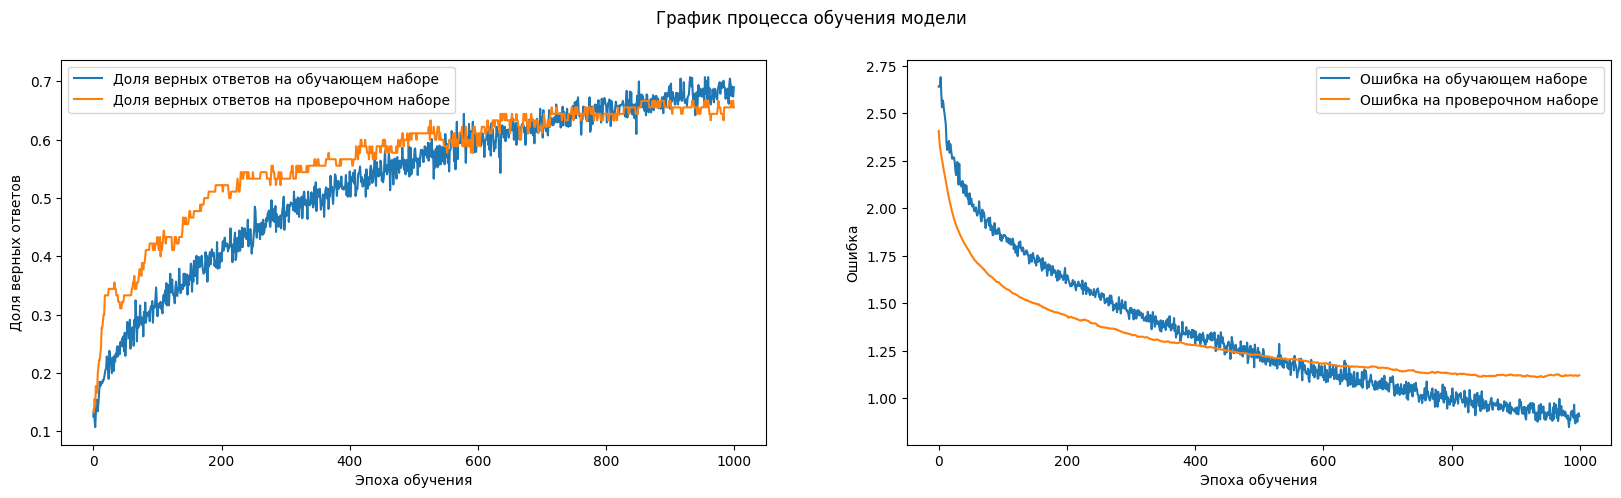

In [22]:
show_history(history)

5. Проверьте работу модели:
 - В разделе **Функции визуализации распознавания отдельных звуковых файлов** найдите определение функции `classify_test_files()` и изучите ее параметры. Используйте функцию для визуализации работы классификатора на произвольном количестве тестовых звуковых файлов, полагая, что:
 - вы используете обученная в задании 4 модель классификатора аудио;
 - нормализатор **x_scaler** уже настроен ранее в ноутбуке, и его нужно передать в функцию `classify_test_files()` вместо параметра **x_scaler**;
 - тестовые звуковые файлы начинаются с индекса **90** и всего их ровно **10** для каждого класса.

Файл: ./genres/blues/blues.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Классификация сети: disco - НЕВЕРНО.


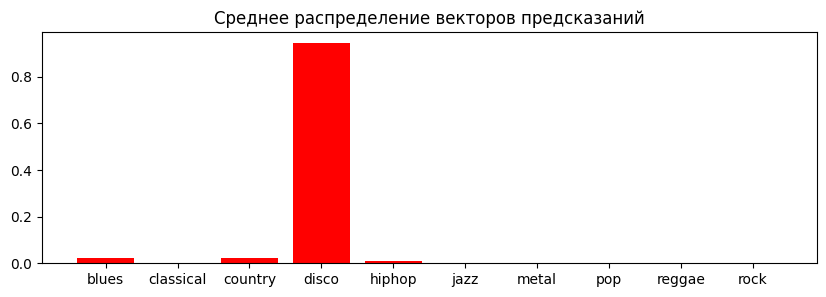

---------------------------------------------------------------
Файл: ./genres/blues/blues.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Классификация сети: metal - НЕВЕРНО.


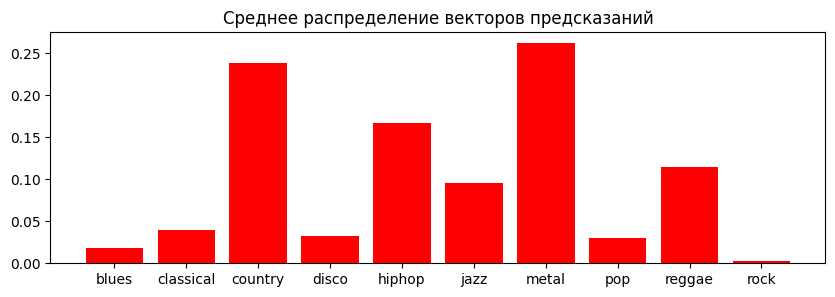

---------------------------------------------------------------
Файл: ./genres/blues/blues.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: disco - НЕВЕРНО.


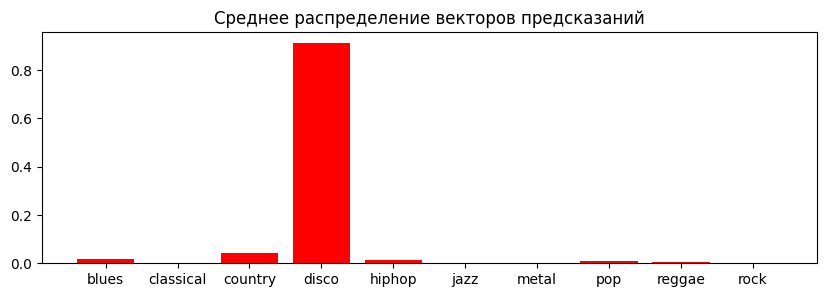

---------------------------------------------------------------
Файл: ./genres/blues/blues.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: disco - НЕВЕРНО.


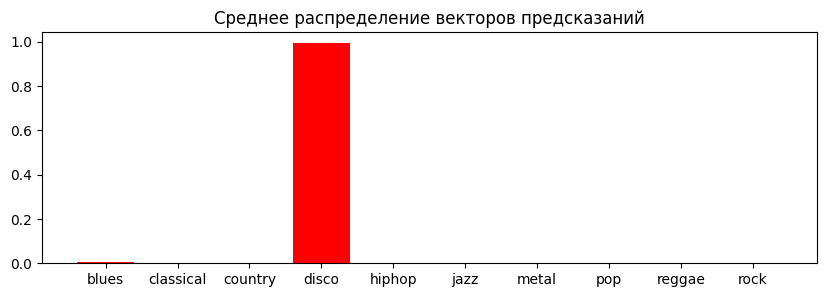

---------------------------------------------------------------
Файл: ./genres/blues/blues.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Классификация сети: disco - НЕВЕРНО.


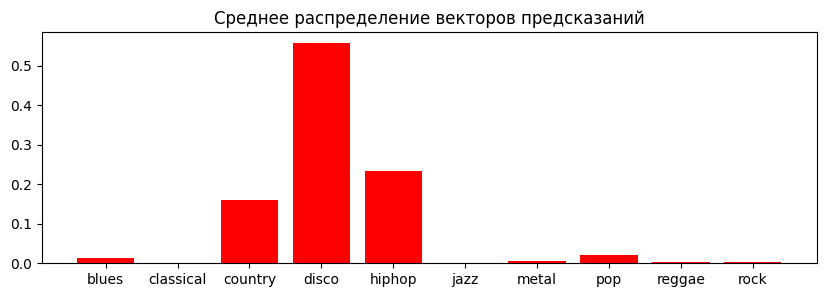

---------------------------------------------------------------
Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: disco - НЕВЕРНО.


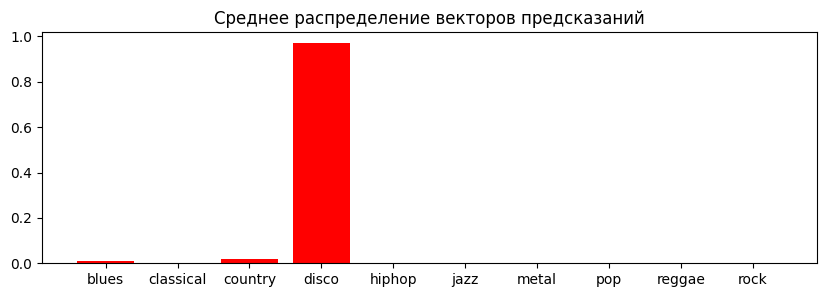

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Классификация сети: hiphop - НЕВЕРНО.


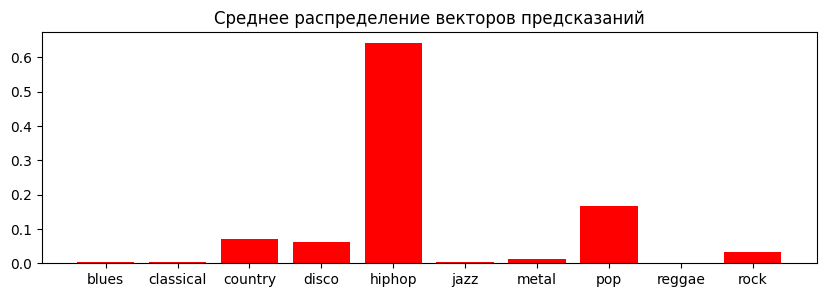

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: disco - НЕВЕРНО.


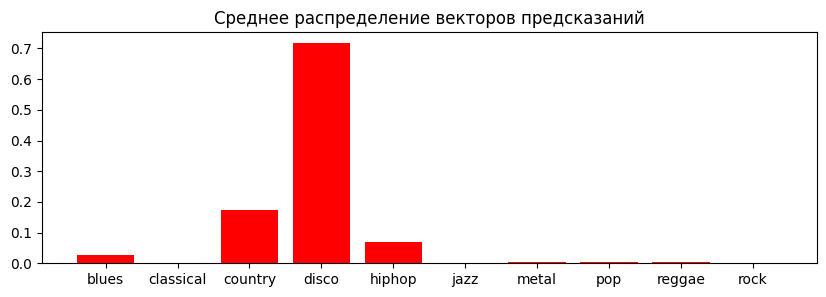

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: blues - ВЕРНО :-)


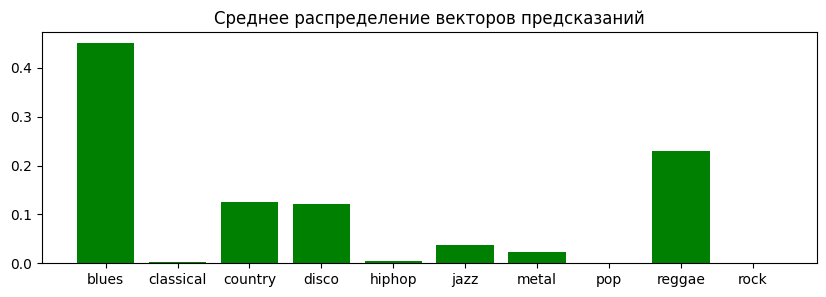

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: pop - НЕВЕРНО.


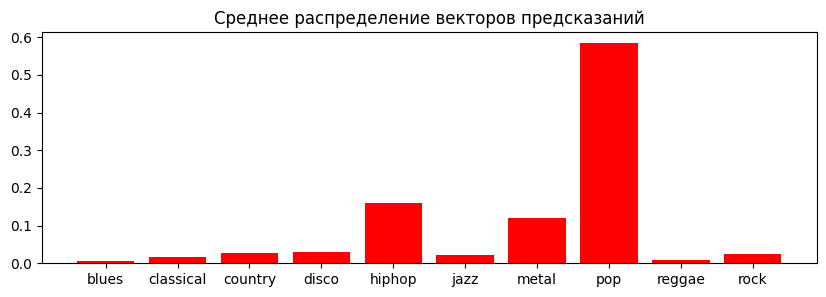

---------------------------------------------------------------
Файл: ./genres/classical/classical.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Классификация сети: rock - НЕВЕРНО.


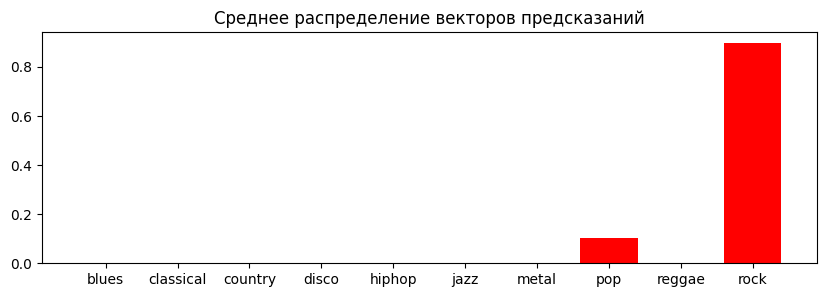

---------------------------------------------------------------
Файл: ./genres/classical/classical.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: rock - НЕВЕРНО.


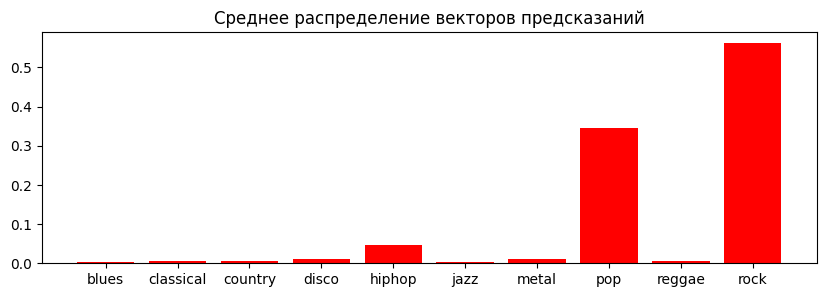

---------------------------------------------------------------
Файл: ./genres/classical/classical.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: rock - НЕВЕРНО.


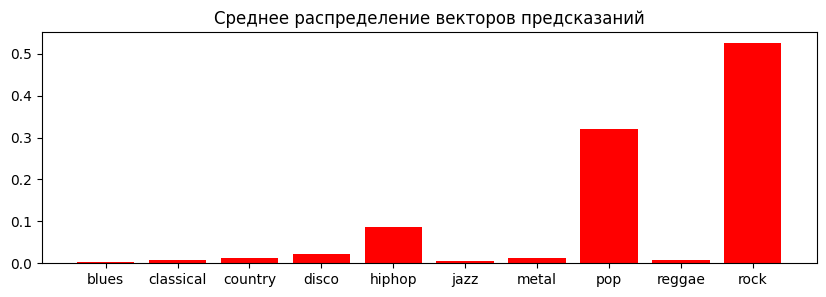

---------------------------------------------------------------
Файл: ./genres/classical/classical.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Классификация сети: pop - НЕВЕРНО.


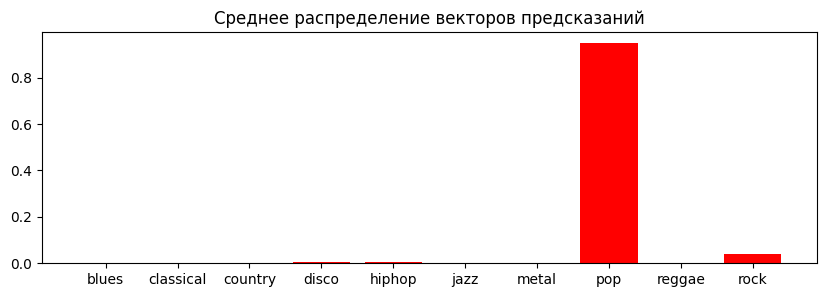

---------------------------------------------------------------
Файл: ./genres/classical/classical.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: rock - НЕВЕРНО.


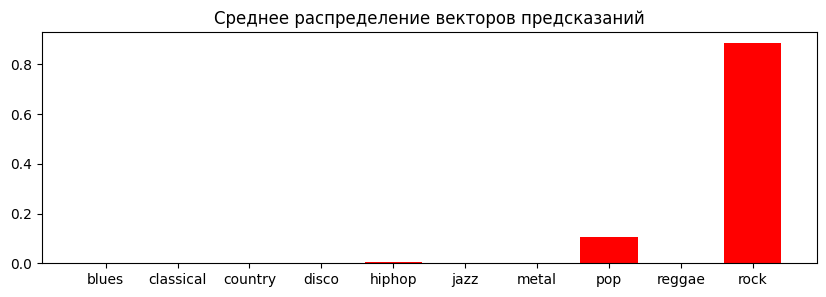

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: rock - НЕВЕРНО.


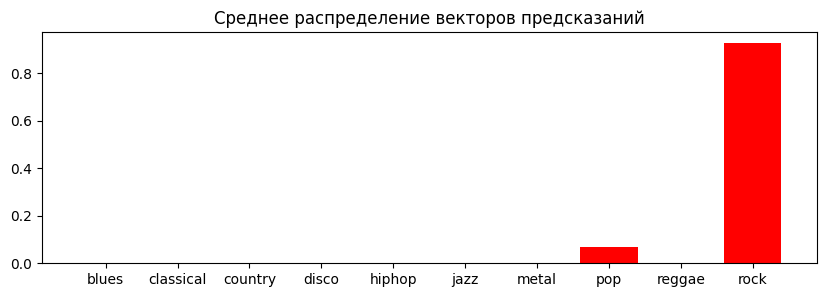

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Классификация сети: rock - НЕВЕРНО.


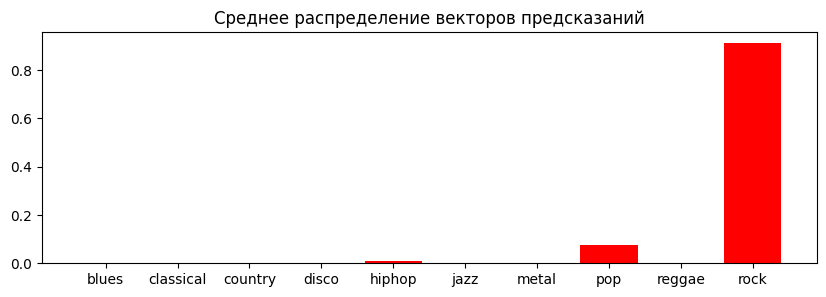

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Классификация сети: rock - НЕВЕРНО.


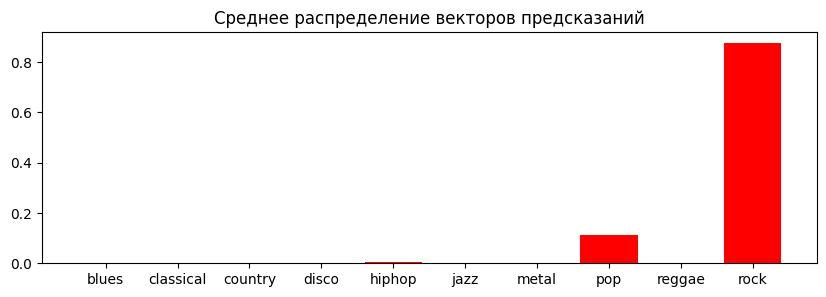

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Классификация сети: pop - НЕВЕРНО.


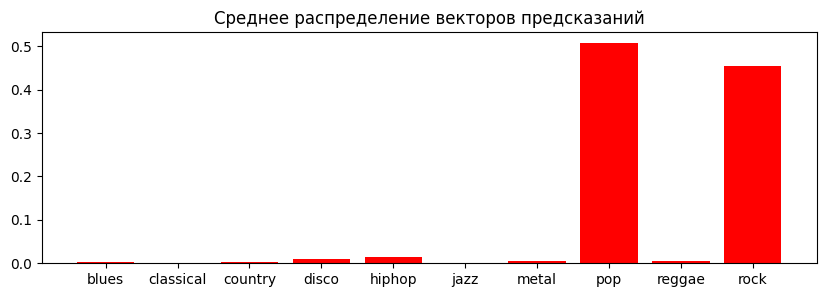

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Классификация сети: rock - НЕВЕРНО.


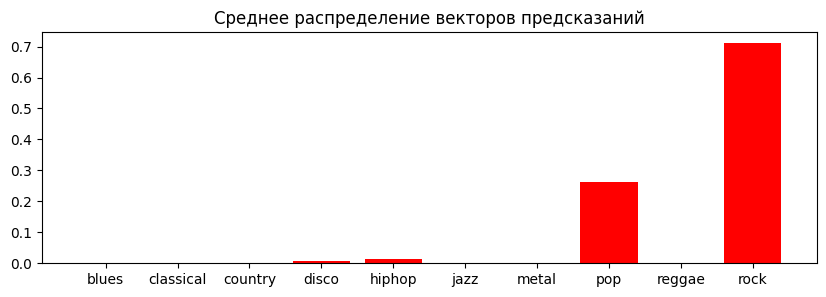

---------------------------------------------------------------
Файл: ./genres/country/country.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: disco - НЕВЕРНО.


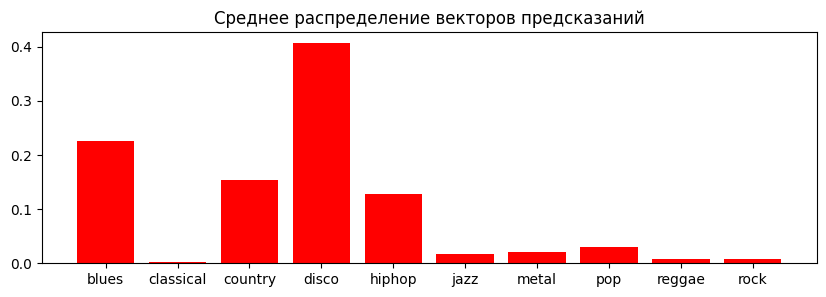

---------------------------------------------------------------
Файл: ./genres/country/country.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: pop - НЕВЕРНО.


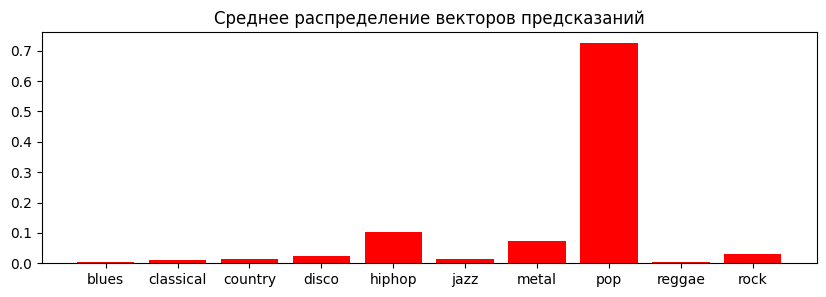

---------------------------------------------------------------
Файл: ./genres/country/country.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: disco - НЕВЕРНО.


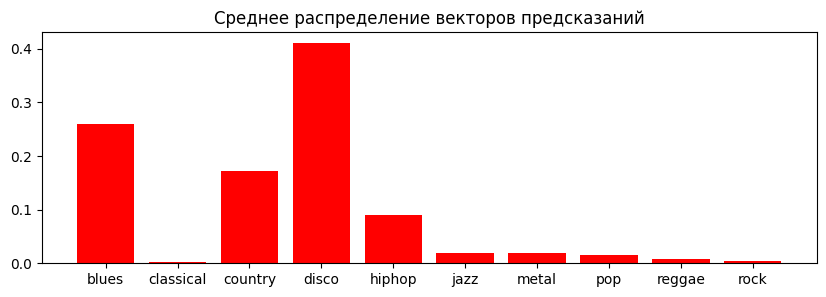

---------------------------------------------------------------
Файл: ./genres/country/country.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Классификация сети: hiphop - НЕВЕРНО.


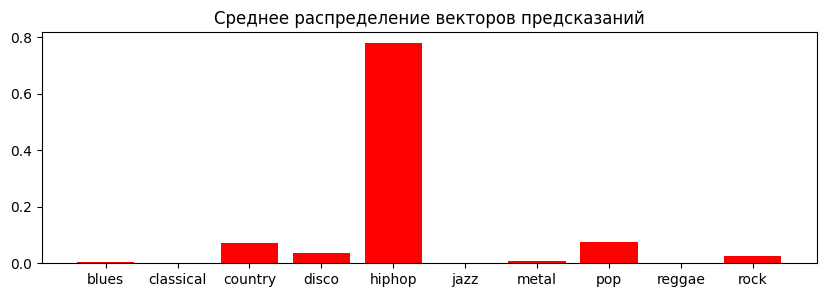

---------------------------------------------------------------
Файл: ./genres/country/country.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Классификация сети: disco - НЕВЕРНО.


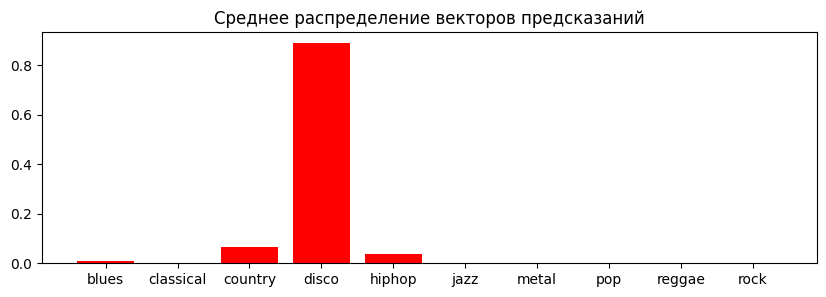

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Классификация сети: pop - НЕВЕРНО.


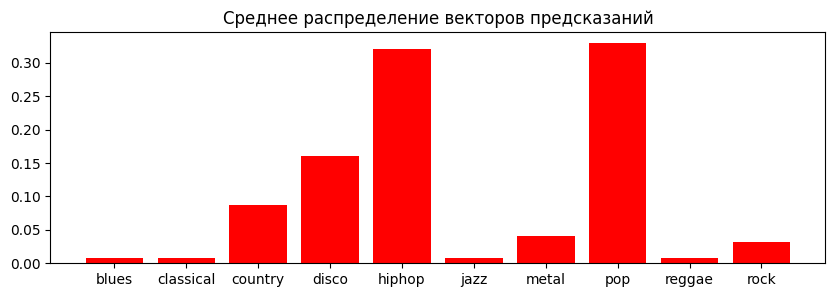

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: country - ВЕРНО :-)


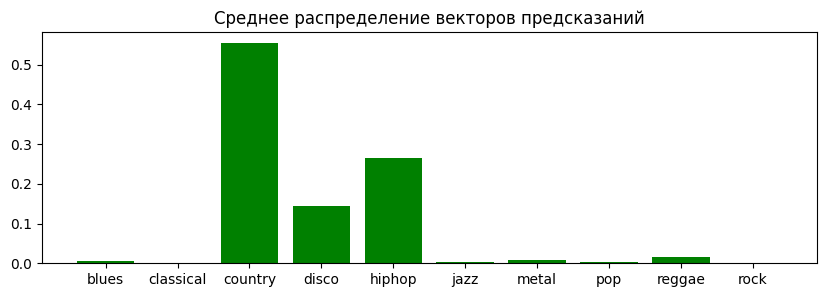

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Классификация сети: hiphop - НЕВЕРНО.


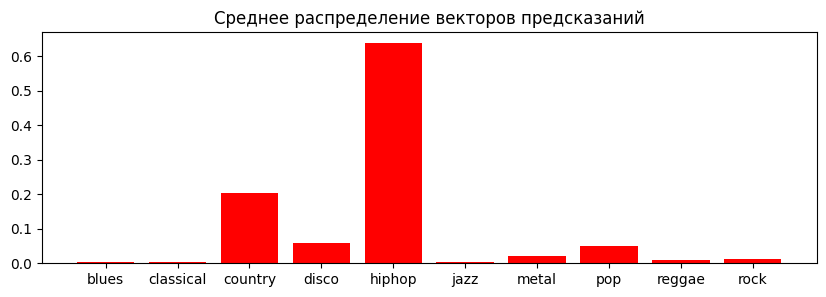

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Классификация сети: disco - НЕВЕРНО.


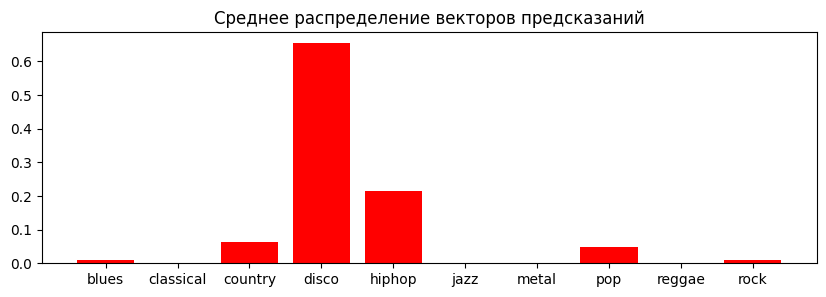

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Классификация сети: country - ВЕРНО :-)


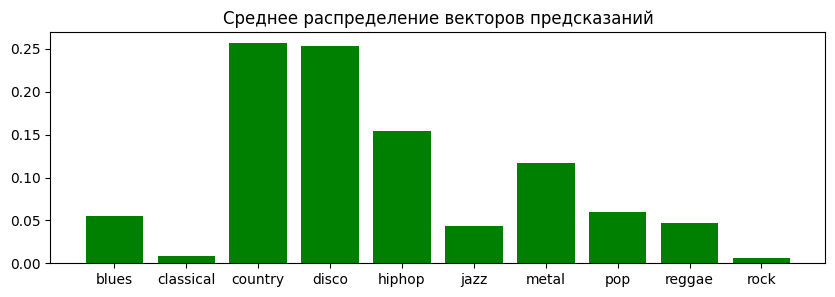

---------------------------------------------------------------
Файл: ./genres/disco/disco.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: reggae - НЕВЕРНО.


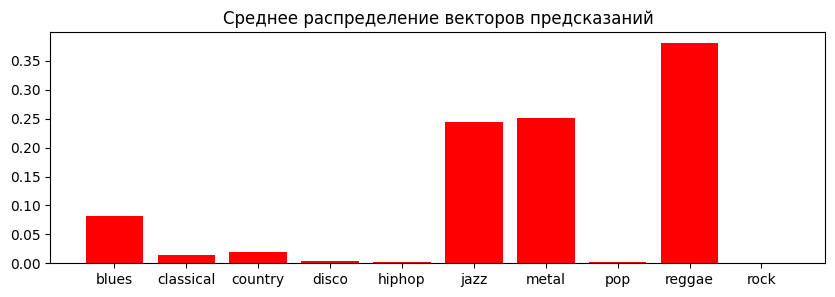

---------------------------------------------------------------
Файл: ./genres/disco/disco.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Классификация сети: country - НЕВЕРНО.


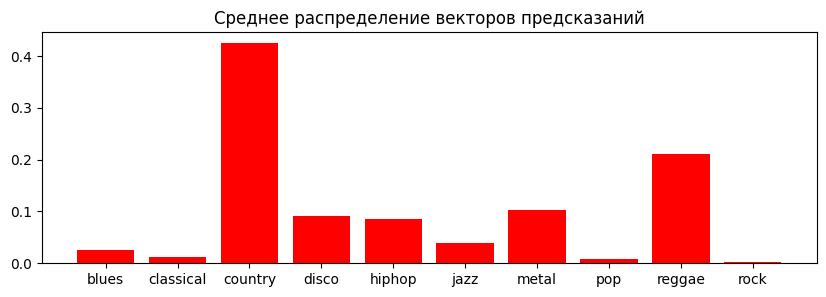

---------------------------------------------------------------
Файл: ./genres/disco/disco.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: metal - НЕВЕРНО.


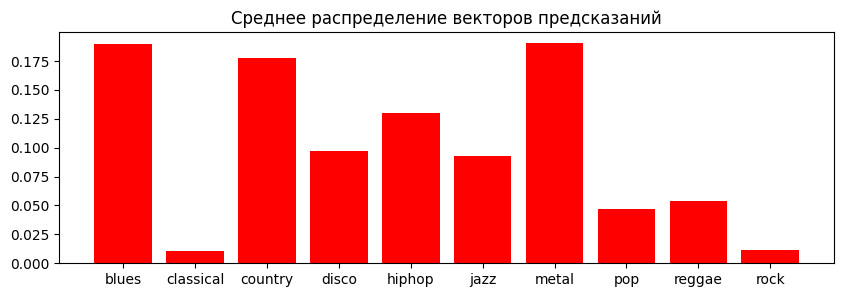

---------------------------------------------------------------
Файл: ./genres/disco/disco.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: blues - НЕВЕРНО.


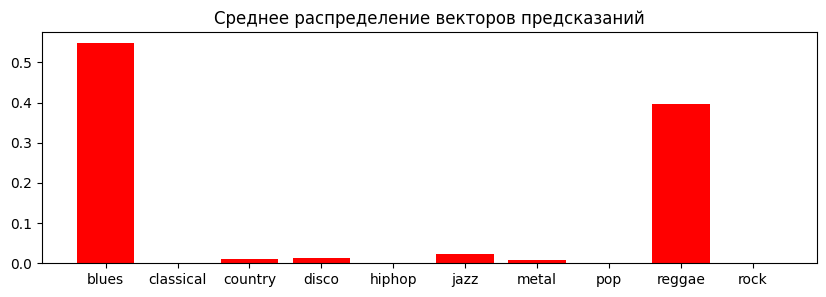

---------------------------------------------------------------
Файл: ./genres/disco/disco.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Классификация сети: disco - ВЕРНО :-)


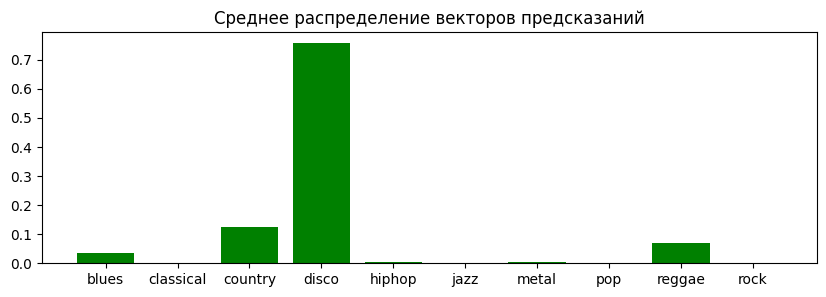

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: blues - НЕВЕРНО.


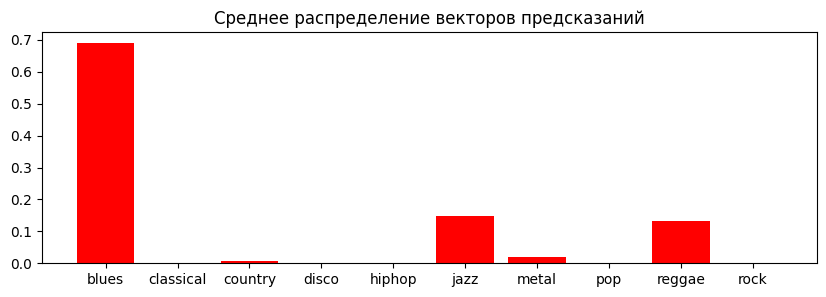

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: blues - НЕВЕРНО.


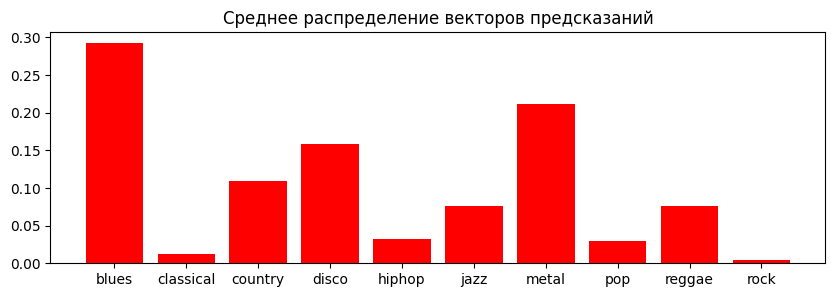

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: reggae - НЕВЕРНО.


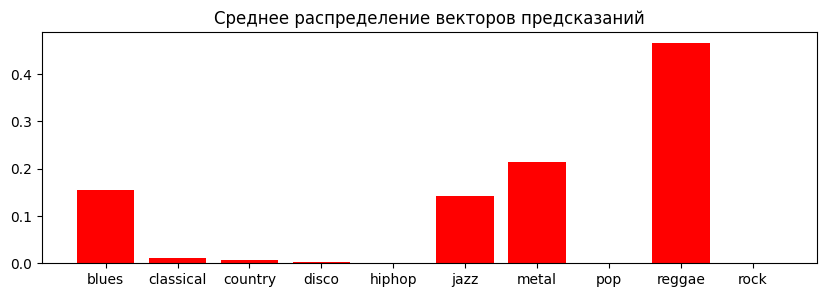

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: reggae - НЕВЕРНО.


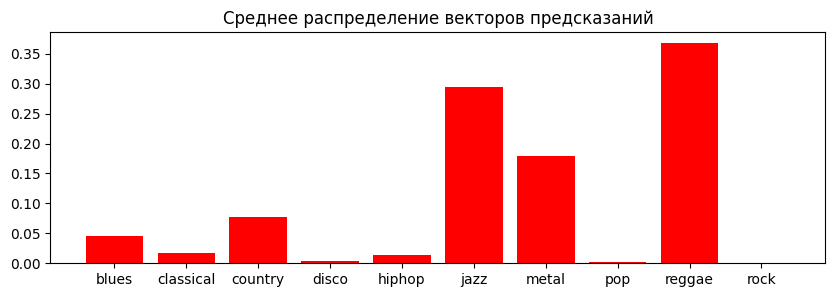

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Классификация сети: reggae - НЕВЕРНО.


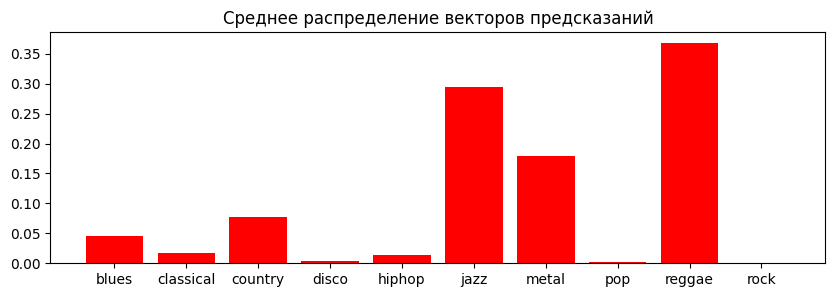

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: jazz - НЕВЕРНО.


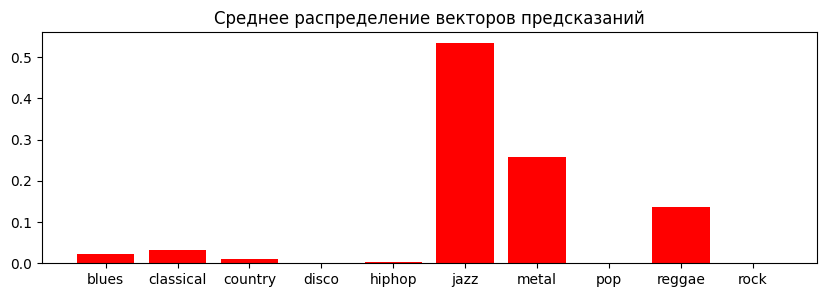

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: jazz - НЕВЕРНО.


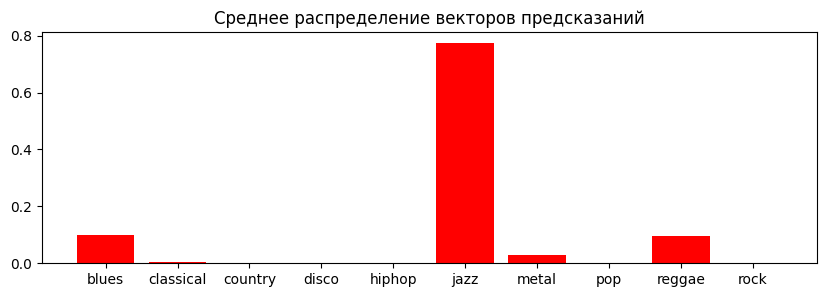

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Классификация сети: metal - НЕВЕРНО.


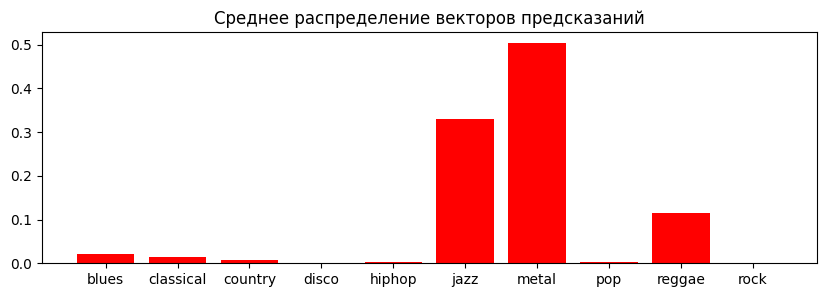

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Классификация сети: blues - НЕВЕРНО.


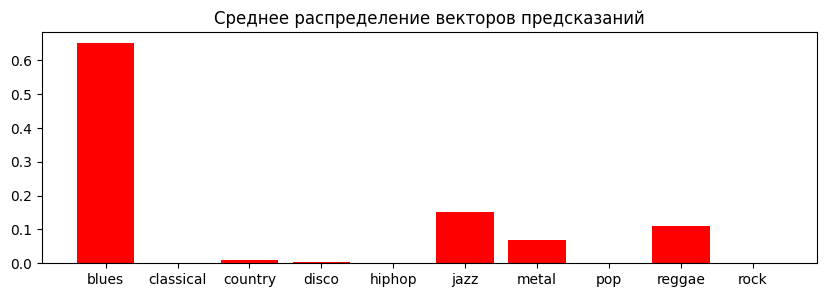

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: jazz - НЕВЕРНО.


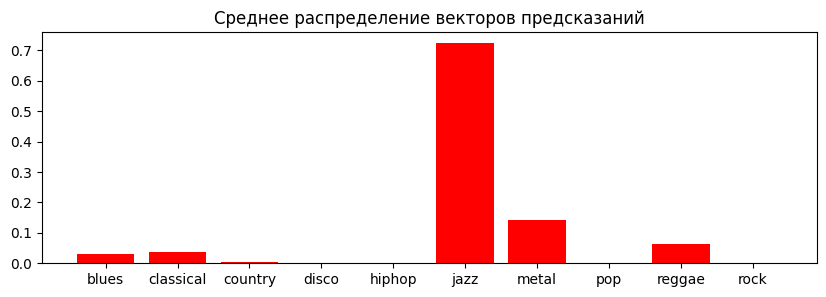

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: jazz - НЕВЕРНО.


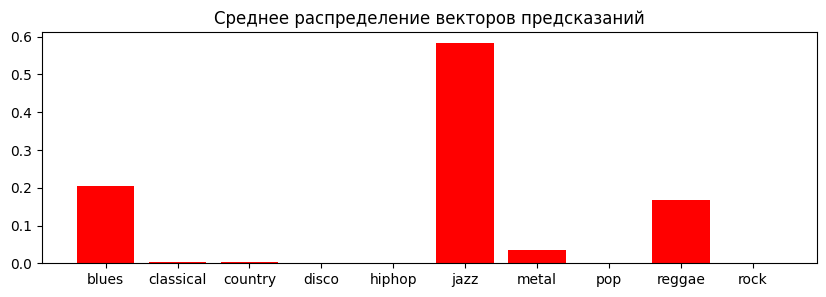

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Классификация сети: jazz - НЕВЕРНО.


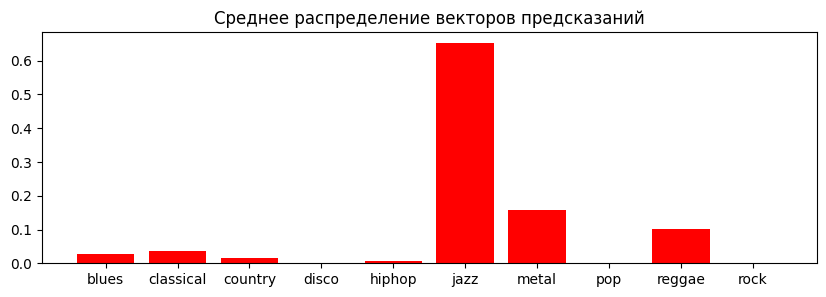

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: jazz - НЕВЕРНО.


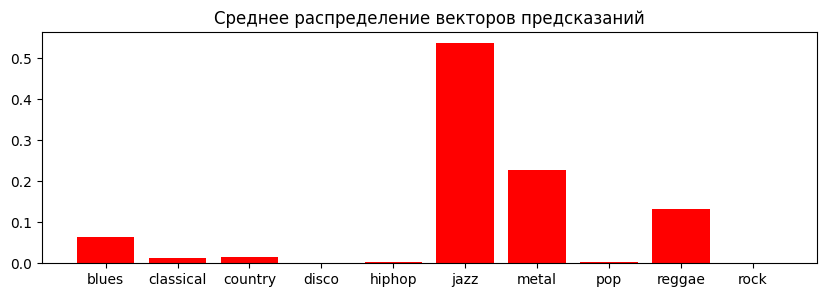

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: jazz - НЕВЕРНО.


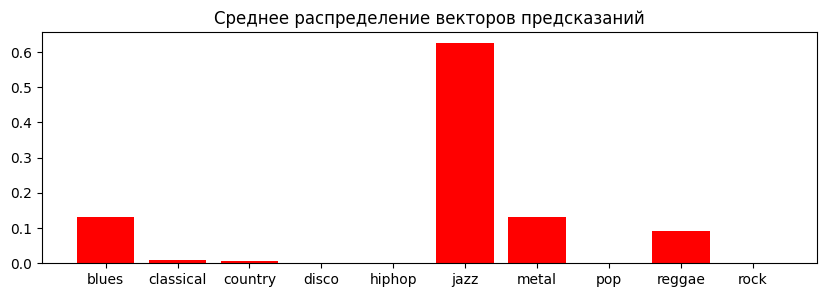

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: country - НЕВЕРНО.


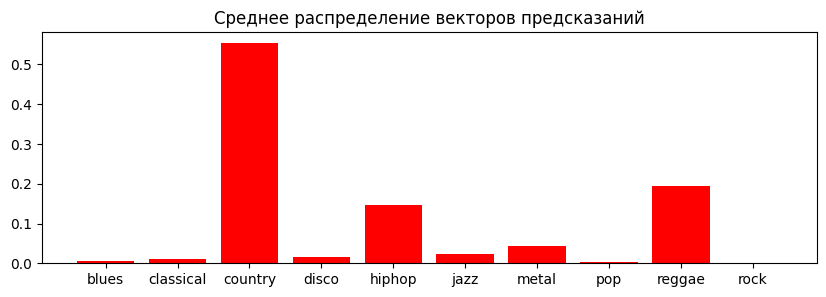

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: pop - НЕВЕРНО.


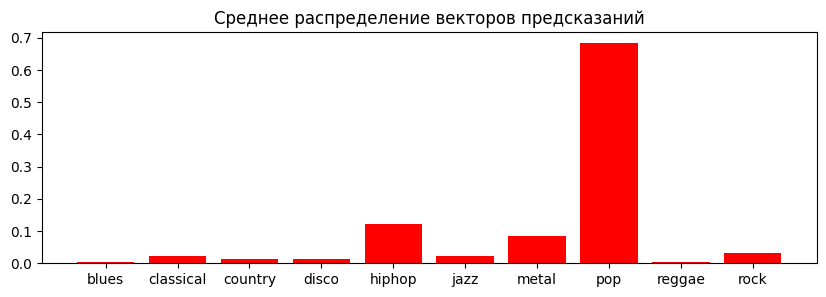

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: pop - НЕВЕРНО.


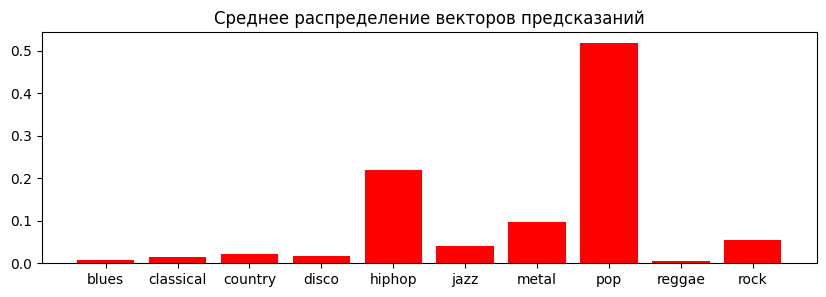

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: pop - НЕВЕРНО.


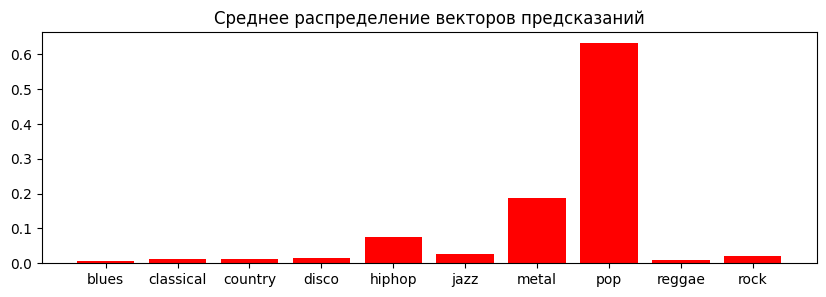

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Классификация сети: pop - НЕВЕРНО.


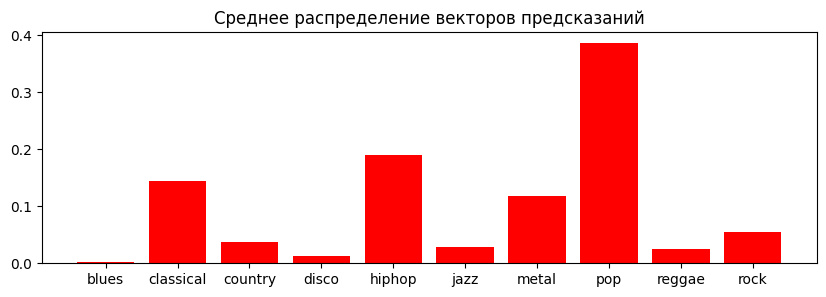

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Классификация сети: pop - НЕВЕРНО.


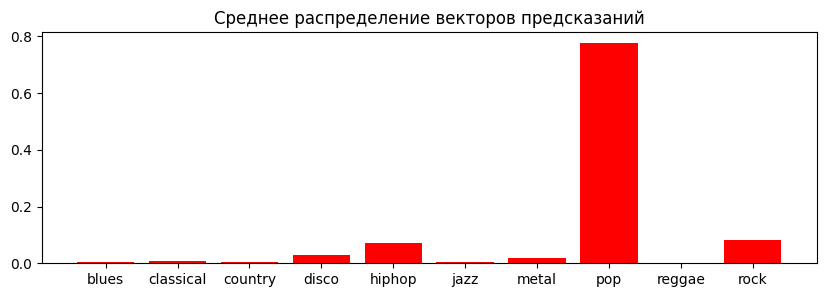

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: metal - НЕВЕРНО.


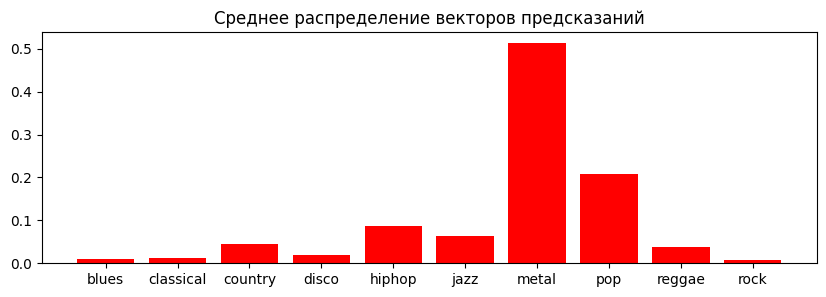

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: pop - НЕВЕРНО.


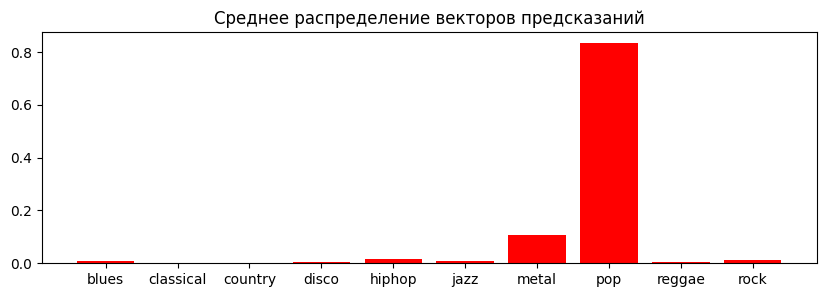

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: pop - НЕВЕРНО.


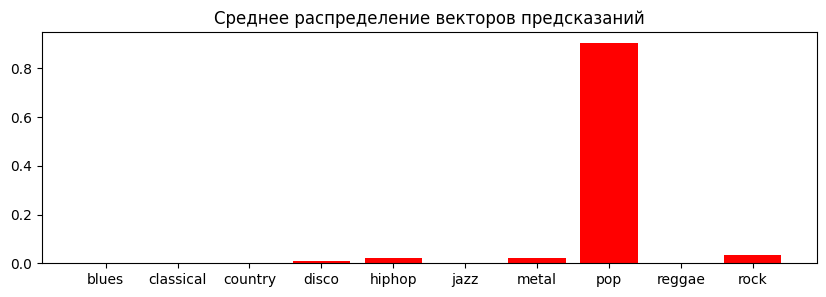

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Классификация сети: metal - НЕВЕРНО.


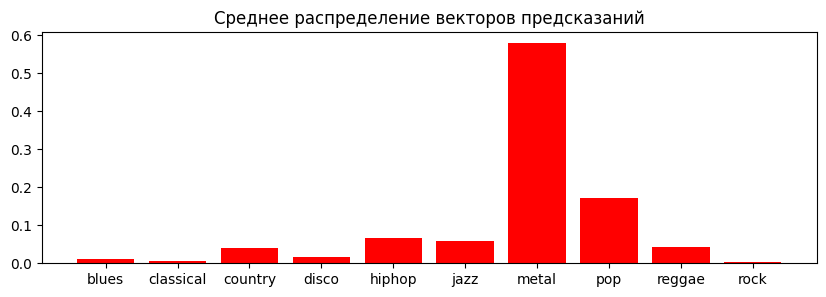

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: pop - НЕВЕРНО.


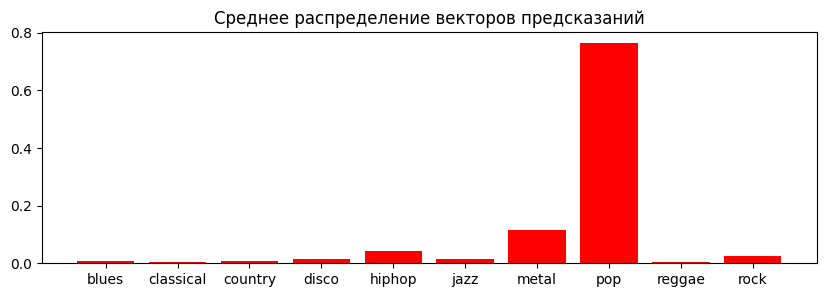

---------------------------------------------------------------
Файл: ./genres/metal/metal.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: metal - ВЕРНО :-)


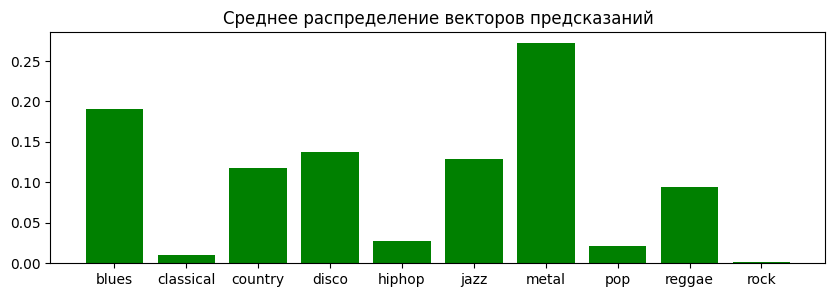

---------------------------------------------------------------
Файл: ./genres/metal/metal.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: metal - ВЕРНО :-)


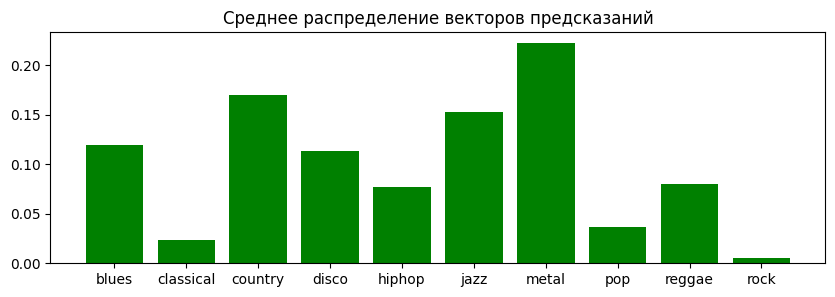

---------------------------------------------------------------
Файл: ./genres/metal/metal.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: hiphop - НЕВЕРНО.


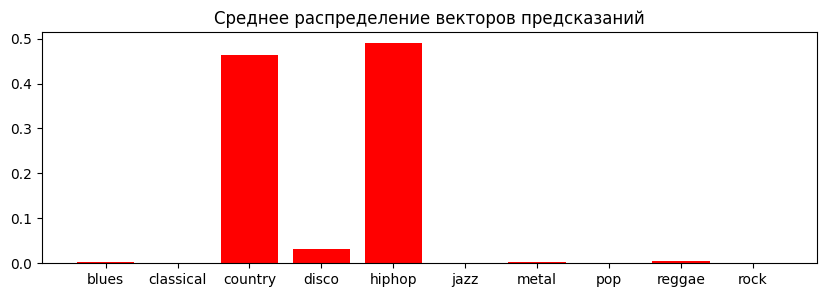

---------------------------------------------------------------
Файл: ./genres/metal/metal.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: blues - НЕВЕРНО.


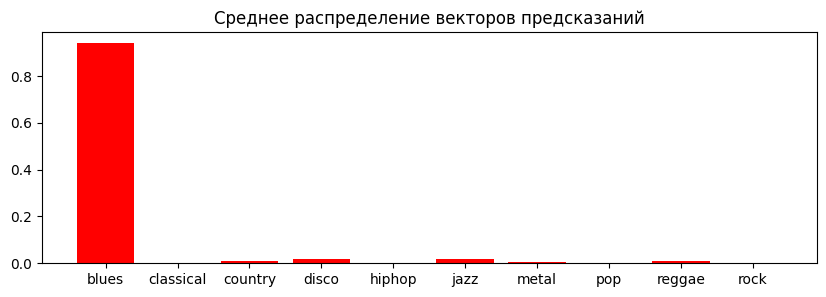

---------------------------------------------------------------
Файл: ./genres/metal/metal.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: blues - НЕВЕРНО.


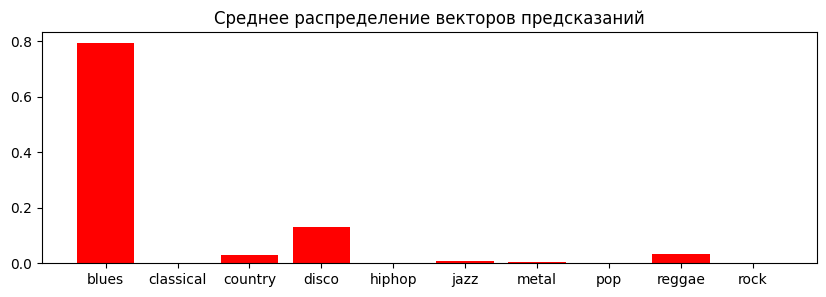

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Классификация сети: blues - НЕВЕРНО.


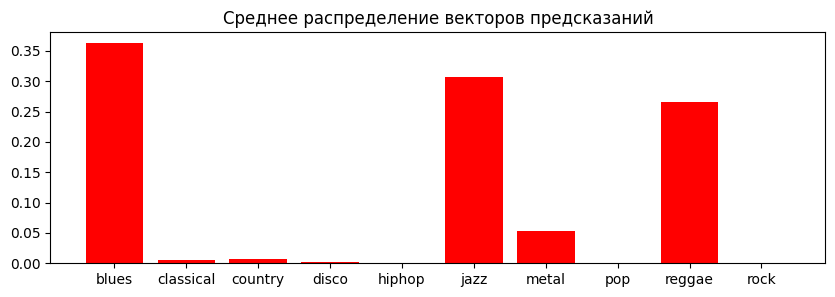

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Классификация сети: blues - НЕВЕРНО.


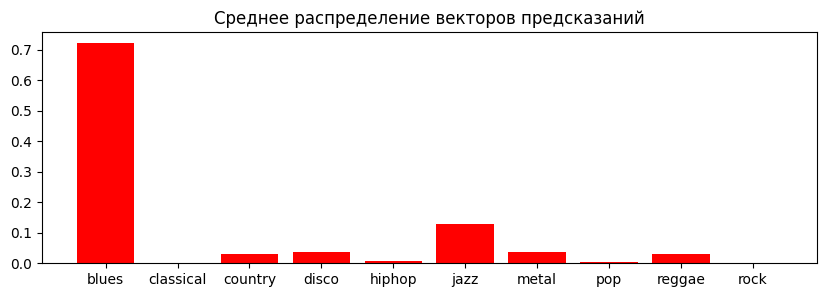

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Классификация сети: blues - НЕВЕРНО.


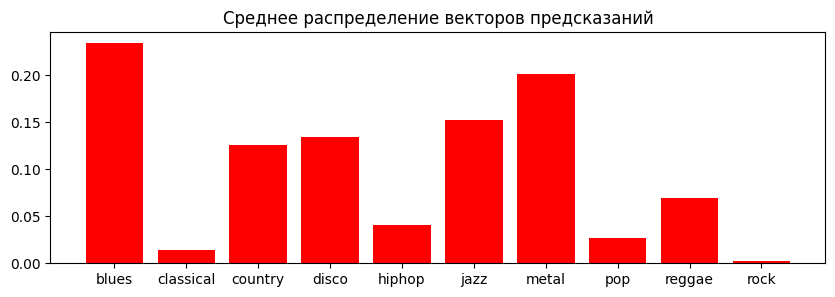

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Классификация сети: blues - НЕВЕРНО.


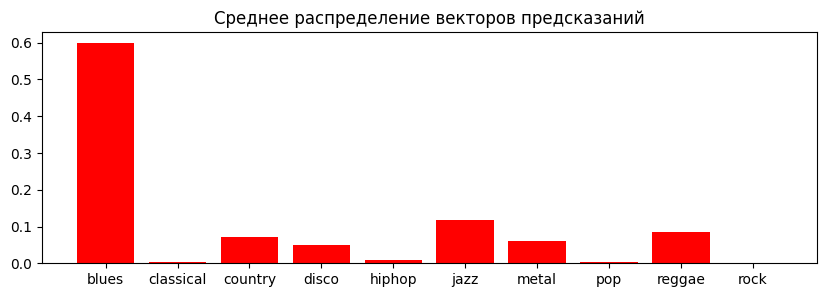

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: jazz - НЕВЕРНО.


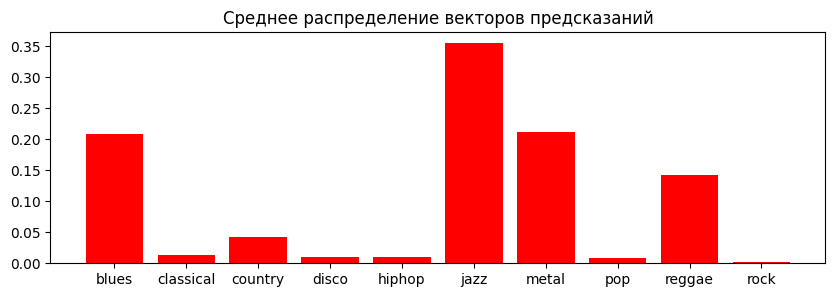

---------------------------------------------------------------
Файл: ./genres/pop/pop.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: classical - НЕВЕРНО.


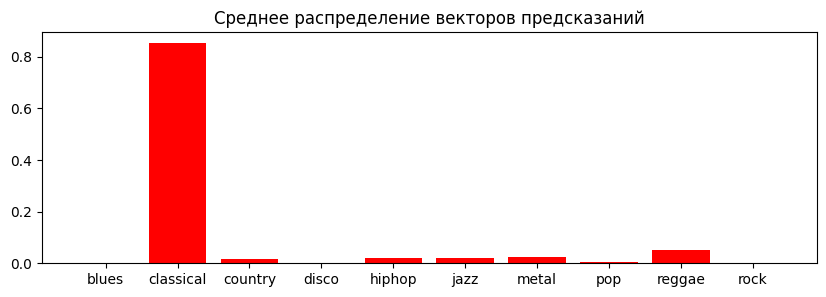

---------------------------------------------------------------
Файл: ./genres/pop/pop.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Классификация сети: classical - НЕВЕРНО.


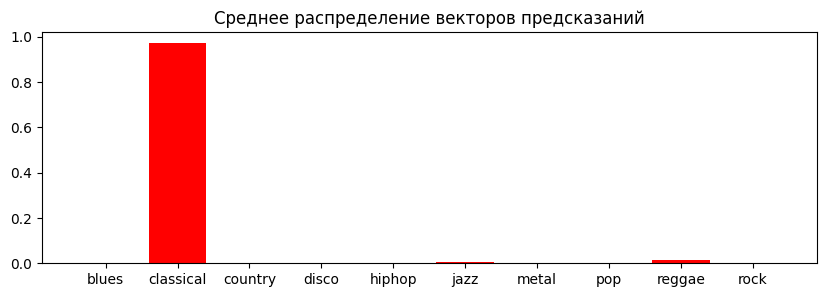

---------------------------------------------------------------
Файл: ./genres/pop/pop.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Классификация сети: classical - НЕВЕРНО.


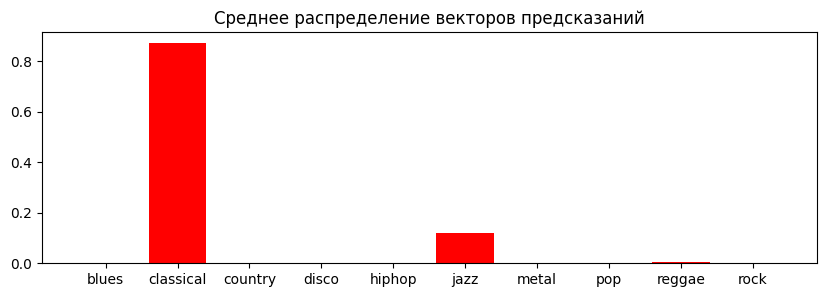

---------------------------------------------------------------
Файл: ./genres/pop/pop.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Классификация сети: classical - НЕВЕРНО.


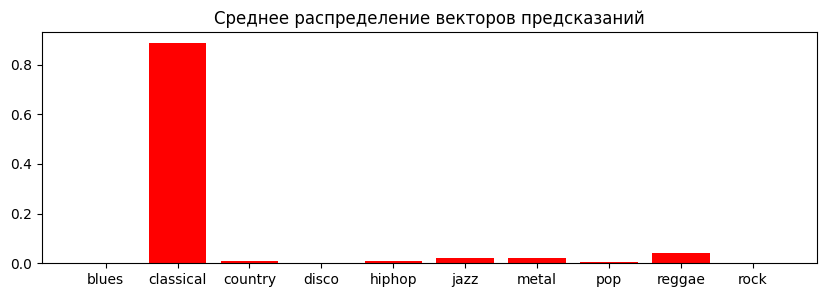

---------------------------------------------------------------
Файл: ./genres/pop/pop.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: classical - НЕВЕРНО.


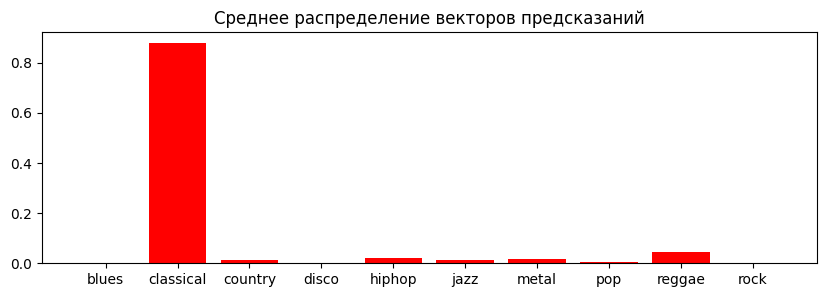

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Классификация сети: classical - НЕВЕРНО.


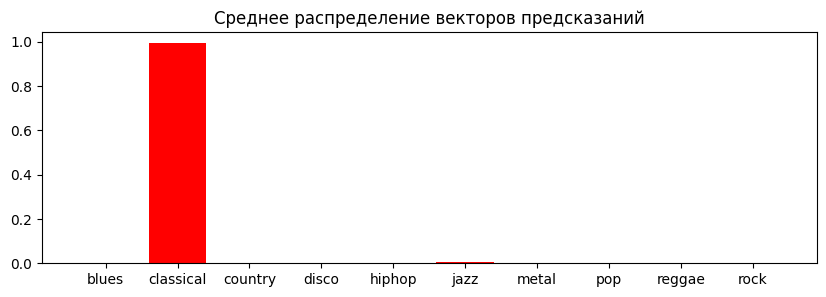

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Классификация сети: classical - НЕВЕРНО.


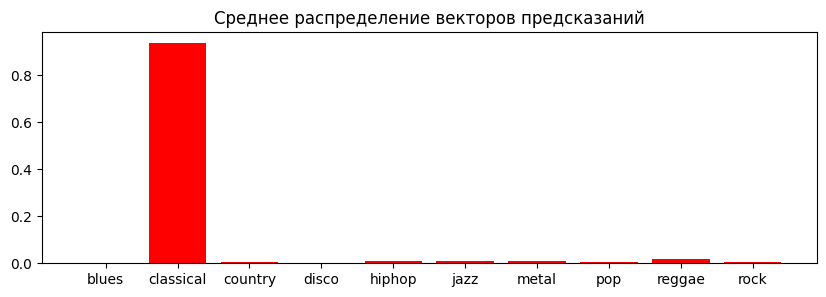

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: classical - НЕВЕРНО.


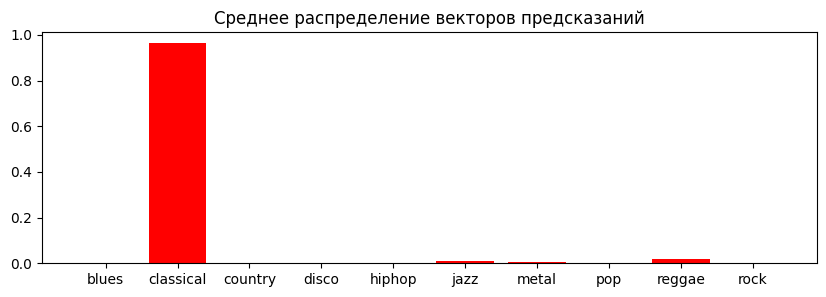

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: classical - НЕВЕРНО.


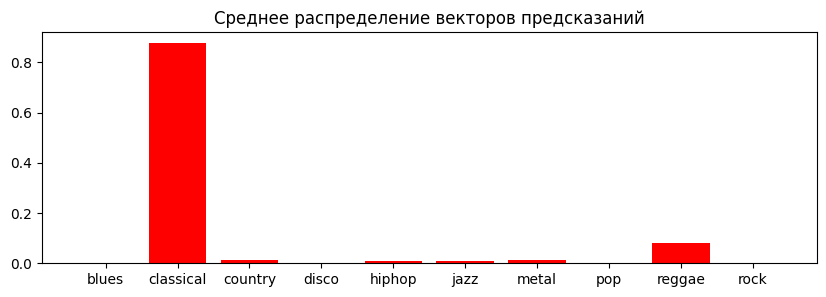

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Классификация сети: classical - НЕВЕРНО.


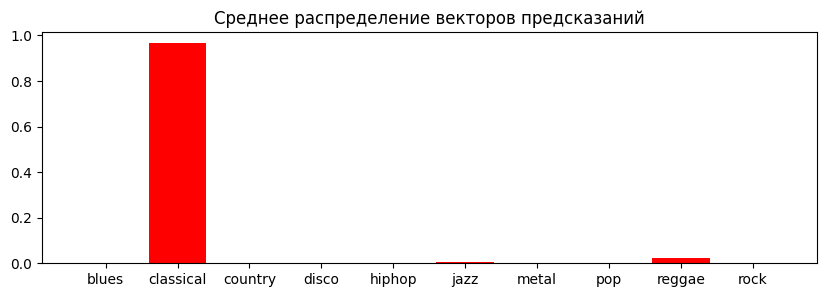

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: reggae - ВЕРНО :-)


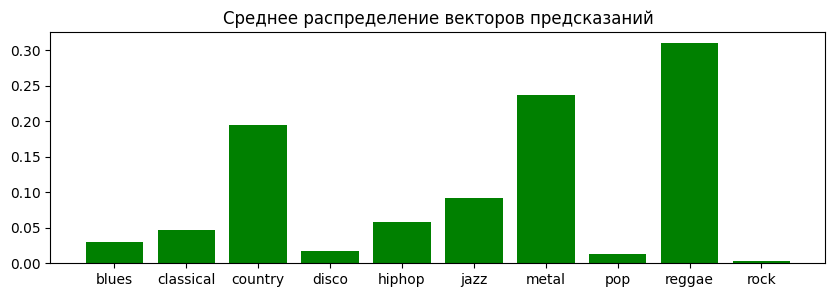

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: metal - НЕВЕРНО.


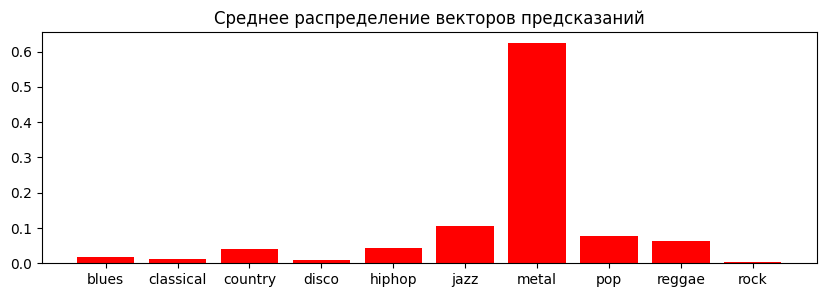

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: metal - НЕВЕРНО.


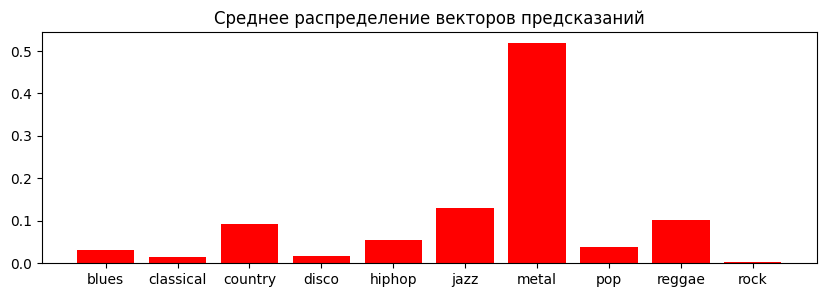

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Классификация сети: classical - НЕВЕРНО.


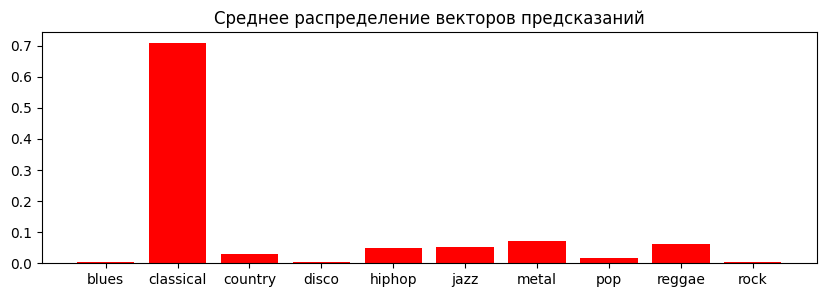

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Классификация сети: hiphop - НЕВЕРНО.


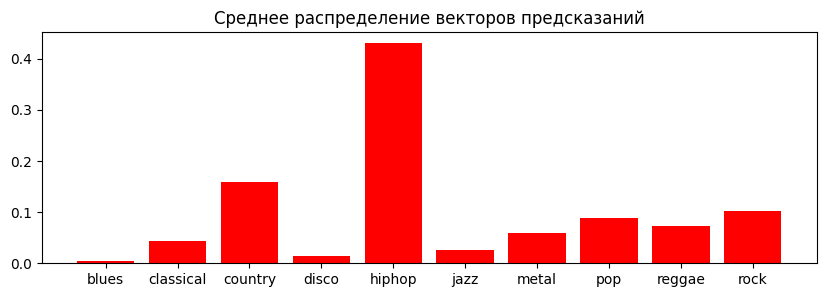

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: jazz - НЕВЕРНО.


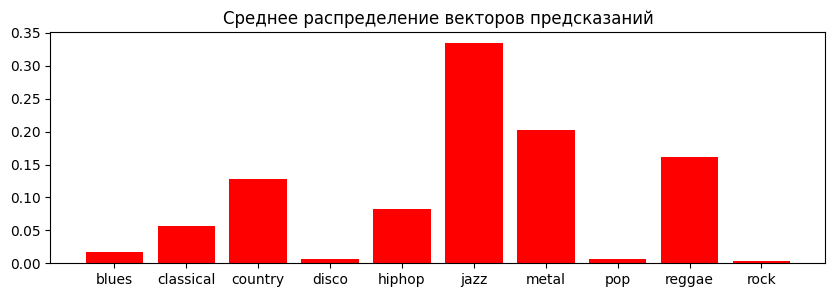

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: metal - НЕВЕРНО.


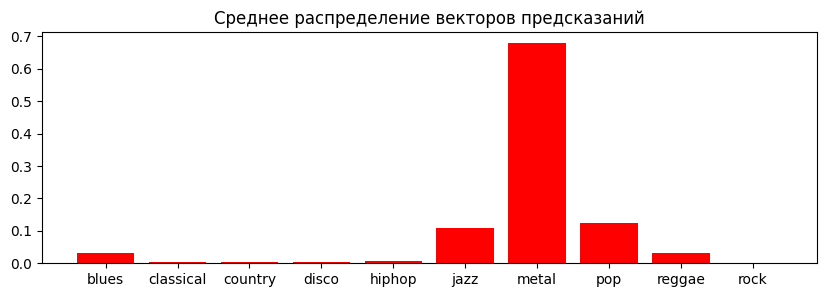

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Классификация сети: hiphop - НЕВЕРНО.


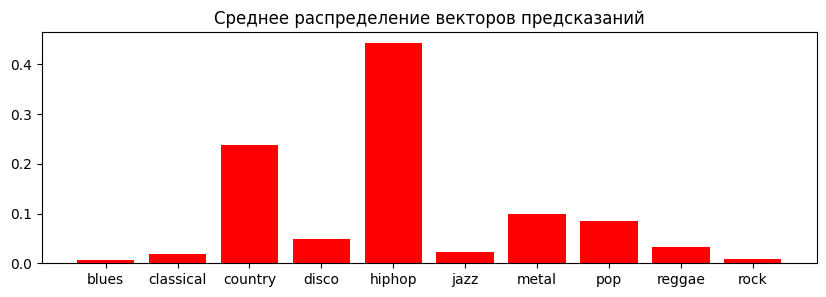

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Классификация сети: metal - НЕВЕРНО.


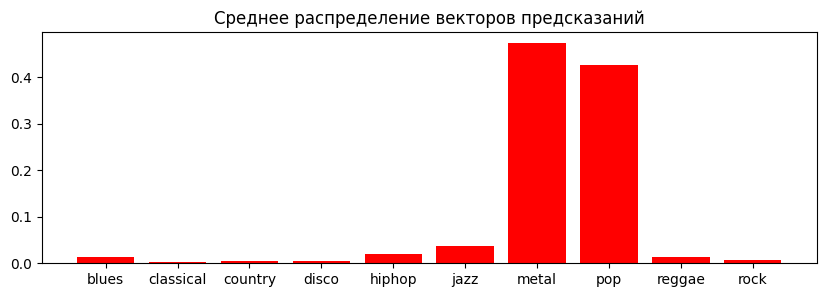

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Классификация сети: jazz - НЕВЕРНО.


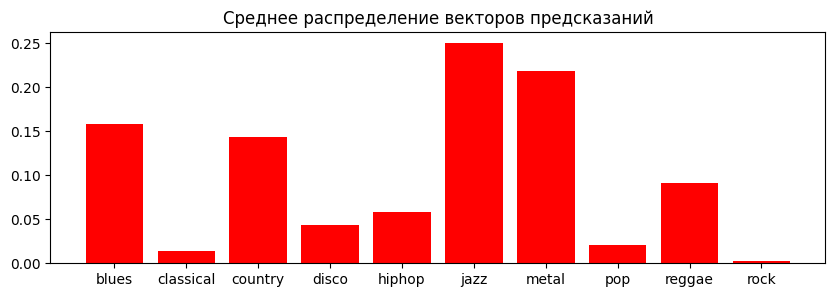

---------------------------------------------------------------
Файл: ./genres/rock/rock.00090.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: pop - НЕВЕРНО.


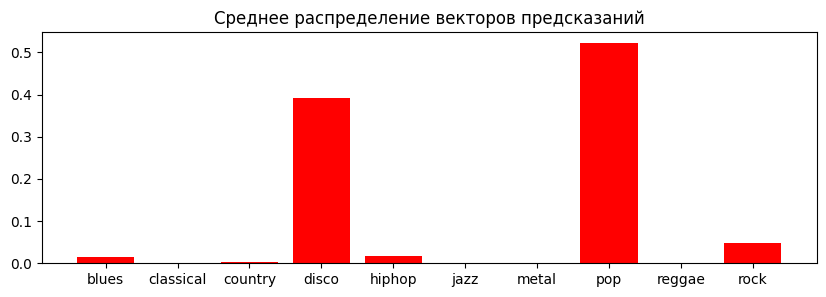

---------------------------------------------------------------
Файл: ./genres/rock/rock.00091.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Классификация сети: reggae - НЕВЕРНО.


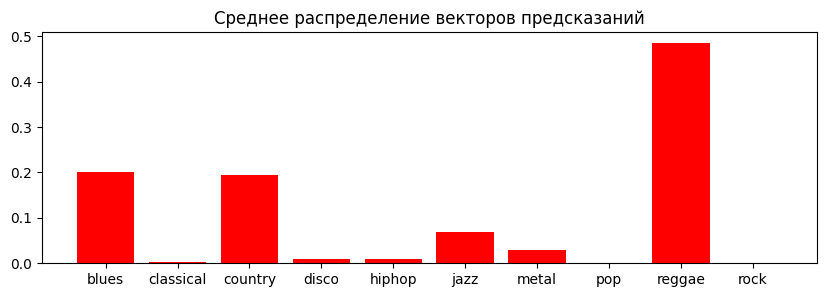

---------------------------------------------------------------
Файл: ./genres/rock/rock.00092.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Классификация сети: disco - НЕВЕРНО.


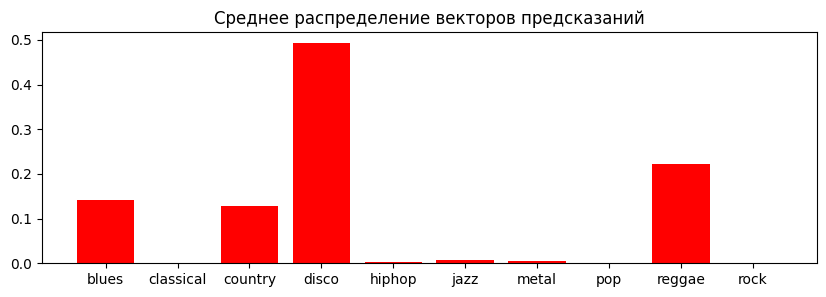

---------------------------------------------------------------
Файл: ./genres/rock/rock.00093.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Классификация сети: disco - НЕВЕРНО.


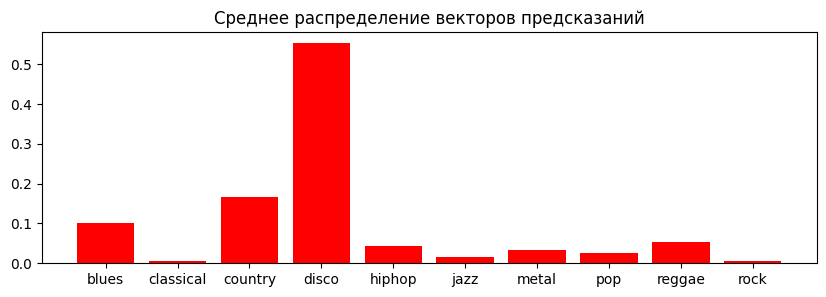

---------------------------------------------------------------
Файл: ./genres/rock/rock.00094.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: disco - НЕВЕРНО.


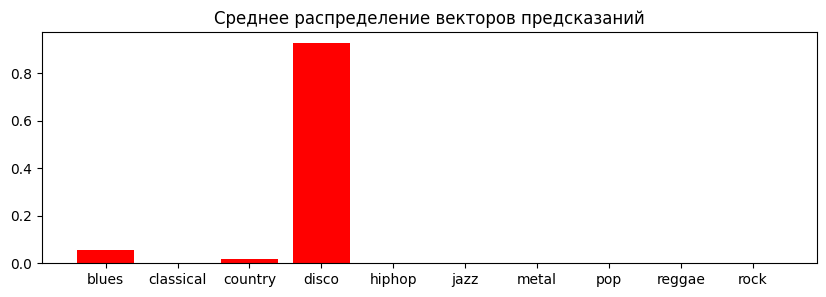

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: hiphop - НЕВЕРНО.


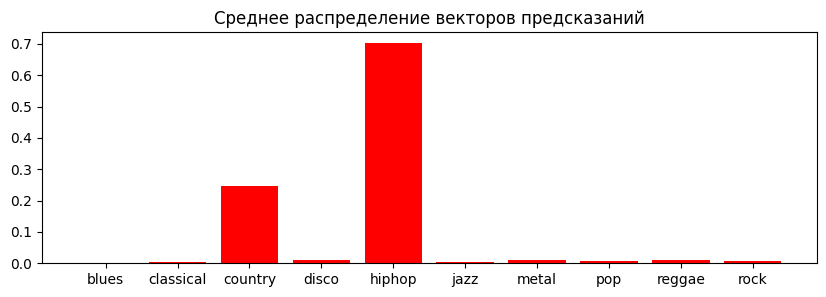

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Классификация сети: hiphop - НЕВЕРНО.


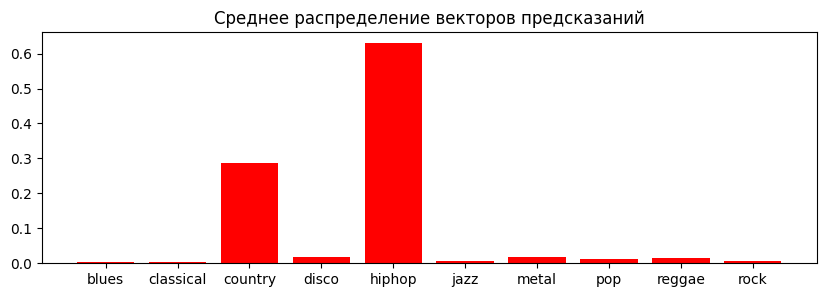

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Классификация сети: country - НЕВЕРНО.


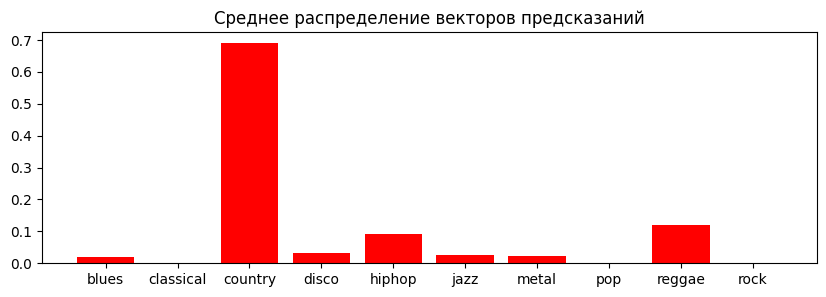

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Классификация сети: hiphop - НЕВЕРНО.


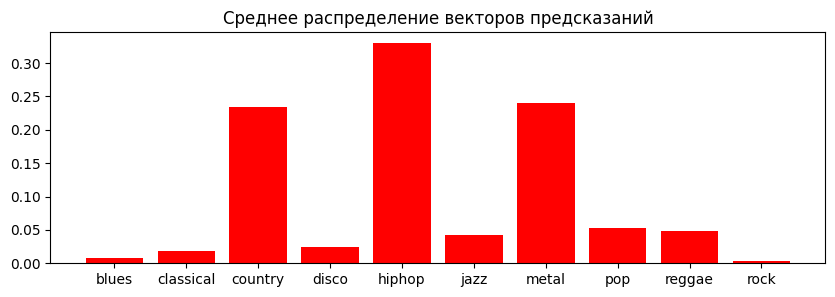

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Векторы для предсказания: (1, 37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Классификация сети: disco - НЕВЕРНО.


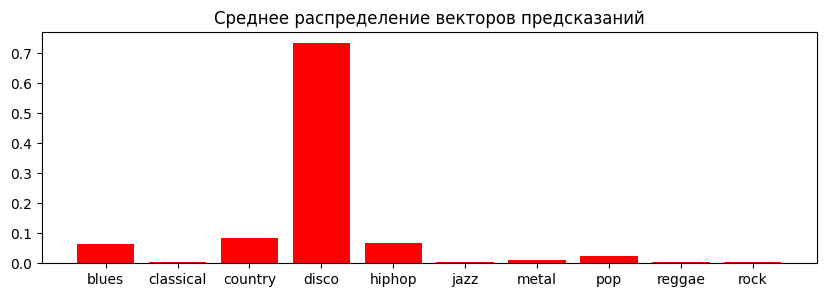

---------------------------------------------------------------
=== Обработано образцов: 100, из них распознано верно: 7, доля верных: 7.0% ===


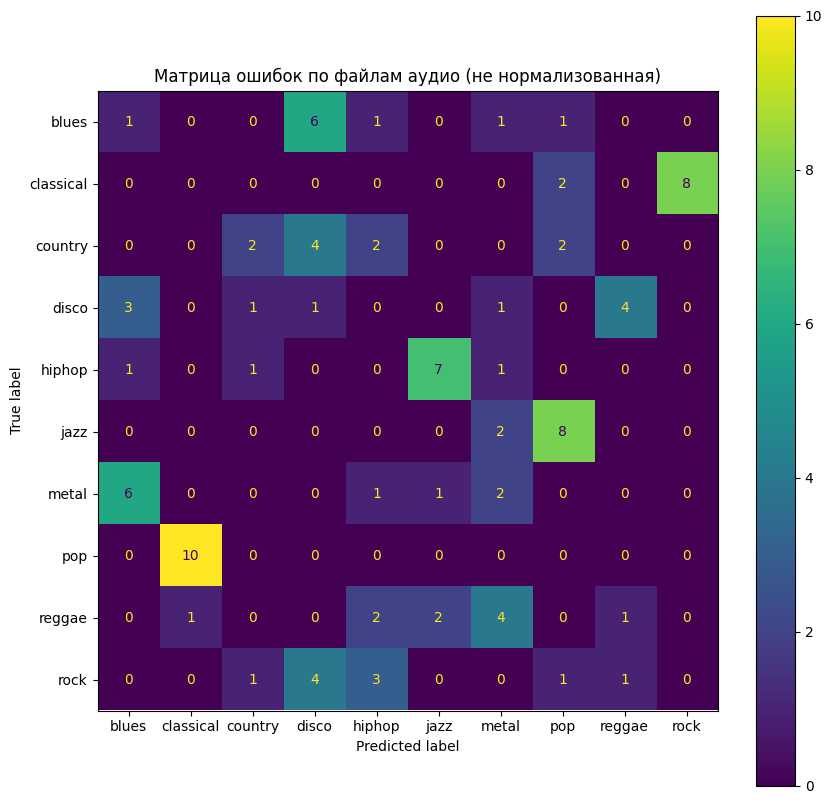

In [24]:
# Ваше решение

classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        90,  # индекс аудиофайла, с которого начинать визуализацию
                        10)